In [1]:
import pandas as pd
from pathlib import Path
from pkg.annotator.backchannel import BackchannelIdentifier
from pkg.preprocess import ConversationMergeStrategy

root_path = Path("/Users/jliu/workspace/Multi-reward/")

In [ ]:
class ConversationMerger:
    """Build canonical child→adult conversation pairs with aggregation."""

    def __init__(self, adult_col="adult_speech", child_col="child_speech", empty_markers=None):
        self.adult_col = adult_col
        self.child_col = child_col
        self.empty_markers = empty_markers or ["<EMPTY>", "<UNINTELLIGIBLE>", ""]

    def _has_special_tag(self, text: str) -> bool:
        if text is None or (isinstance(text, float) and pd.isna(text)):
            return True
        text = str(text).strip()
        return any(marker.upper() == text.upper() for marker in self.empty_markers)

    def recover_sequential(self, df: pd.DataFrame, filter_special=True) -> pd.DataFrame:
        """
        Convert original DataFrame into sequential turn-by-turn.
        Keeps original columns for reference.
        """
        seq_rows = []
        for _, row in df.iterrows():
            adult_text = str(row[self.adult_col]).strip()
            child_text = str(row[self.child_col]).strip()

            if not filter_special or not self._has_special_tag(adult_text):
                new_row = row.to_dict()
                new_row.update({"speaker": "ADULT", "utterance": adult_text})
                seq_rows.append(new_row)

            if not filter_special or not self._has_special_tag(child_text):
                new_row = row.to_dict()
                new_row.update({"speaker": "CHI", "utterance": child_text})
                seq_rows.append(new_row)

        return pd.DataFrame(seq_rows)

    def aggregate_consecutive(self, df: pd.DataFrame) -> pd.DataFrame:
        """Aggregate consecutive turns from the same speaker."""
        if df.empty:
            return df

        agg_rows = []
        current_speaker = df.iloc[0]["speaker"]
        current_text = [df.iloc[0]["utterance"]]
        current_meta = df.iloc[0].drop(["speaker", "utterance"]).to_dict()

        for idx in range(1, len(df)):
            row = df.iloc[idx]
            row_meta = row.drop(["speaker", "utterance"]).to_dict()

            if row["speaker"] == current_speaker:
                current_text.append(row["utterance"])
                # Optionally merge metadata if needed, for now keep first
            else:
                merged_row = current_meta.copy()
                merged_row.update({"speaker": current_speaker, "utterance": " ".join(current_text)})
                agg_rows.append(merged_row)

                current_speaker = row["speaker"]
                current_text = [row["utterance"]]
                current_meta = row_meta

        # append last
        merged_row = current_meta.copy()
        merged_row.update({"speaker": current_speaker, "utterance": " ".join(current_text)})
        agg_rows.append(merged_row)

        return pd.DataFrame(agg_rows)

    def build_child_prompted_pairs(self, df: pd.DataFrame, filter_special=True) -> pd.DataFrame:
        """
        Build canonical child->adult pairs from aggregated sequential DataFrame.
        Preserves original columns.
        """
        seq_df = self.recover_sequential(df, filter_special=filter_special)
        agg_df = self.aggregate_consecutive(seq_df)

        rows = []
        for i in range(len(agg_df) - 1):
            if agg_df.iloc[i]["speaker"] == "CHI" and agg_df.iloc[i+1]["speaker"] == "ADULT":
                # Combine metadata from both turns
                combined_row = {}
                # Include all original columns from child turn (or merge adult if needed)
                combined_row.update({k: agg_df.iloc[i][k] for k in df.columns if k in agg_df.columns})
                combined_row.update({
                    "child_speech": agg_df.iloc[i]["utterance"],
                    "adult_speech": agg_df.iloc[i+1]["utterance"]
                })
                rows.append(combined_row)

        return pd.DataFrame(rows).reset_index(drop=True)



# --------------------------------------------------
# Stats / diagnostics (before & after filtering)
# --------------------------------------------------

class ConversationStats:
    def __init__(self, text_col: str):
        self.text_col = text_col

    def compute(self, df: pd.DataFrame) -> Dict[str, float]:
        if df.empty:
            return {
                "n_rows": 0,
                "mean_len": 0.0,
                "median_len": 0.0
            }

        lengths = df[self.text_col].str.split().apply(len)
        return {
            "n_rows": len(df),
            "mean_len": lengths.mean(),
            "median_len": lengths.median()
        }

    def plot_length_distribution(self, df: pd.DataFrame, title: str):
        if df.empty:
            print("Empty dataframe, nothing to plot.")
            return

        lengths = df[self.text_col].str.split().apply(len)
        plt.hist(lengths, bins=30)
        plt.xlabel("Utterance length (words)")
        plt.ylabel("Count")
        plt.title(title)
        plt.show()



In [36]:
import pandas as pd

class ConversationMerger:
    """Build canonical child→adult conversation pairs with pre-filtering and aggregation."""

    def __init__(self, adult_col="adult_speech", child_col="child_speech",
                 empty_markers=None, max_turn_words=50, max_turns=10):
        self.adult_col = adult_col
        self.child_col = child_col
        self.empty_markers = empty_markers or ["<EMPTY>", "<UNINTELLIGIBLE>", ""]
        self.max_turn_words = max_turn_words
        self.max_turns = max_turns

    def _has_special_tag(self, text: str) -> bool:
        if text is None or (isinstance(text, float) and pd.isna(text)):
            return True
        text = str(text).strip()
        return any(marker.upper() == text.upper() for marker in self.empty_markers)

    def _pre_filter_dialogue(self, df: pd.DataFrame) -> bool:
        """Return True if the dialogue should be skipped (empty DF)."""
        adult_valid = df[~df[self.adult_col].apply(self._has_special_tag)]
        child_valid = df[~df[self.child_col].apply(self._has_special_tag)]
        # If only one speaker has valid utterances
        return adult_valid.empty or child_valid.empty

    def recover_sequential(self, df: pd.DataFrame, filter_special=True) -> pd.DataFrame:
        """Convert original DataFrame into sequential turn-by-turn."""
        if filter_special and self._pre_filter_dialogue(df):
            return pd.DataFrame()

        seq_rows = []
        for _, row in df.iterrows():
            child_text = str(row[self.child_col]).strip()
            adult_text = str(row[self.adult_col]).strip()

            # Child first
            if not filter_special or not self._has_special_tag(child_text):
                new_row = row.to_dict()
                new_row.update({"speaker": "CHI", "utterance": child_text})
                seq_rows.append(new_row)

            # Adult second
            if not filter_special or not self._has_special_tag(adult_text):
                new_row = row.to_dict()
                new_row.update({"speaker": "ADULT", "utterance": adult_text})
                seq_rows.append(new_row)

        return pd.DataFrame(seq_rows)

    def aggregate_consecutive(self, df: pd.DataFrame) -> pd.DataFrame:
        """Aggregate consecutive turns from the same speaker with max limits."""
        if df.empty:
            return df

        agg_rows = []
        current_speaker = df.iloc[0]["speaker"]
        current_text = [df.iloc[0]["utterance"]]
        current_meta = df.iloc[0].drop(["speaker", "utterance"]).to_dict()
        current_turn_count = 1

        for idx in range(1, len(df)):
            row = df.iloc[idx]
            row_meta = row.drop(["speaker", "utterance"]).to_dict()

            if row["speaker"] == current_speaker:
                current_text.append(row["utterance"])
                current_turn_count += 1
            else:
                merged_text = " ".join(current_text)
                if current_turn_count > self.max_turns or len(merged_text.split()) > self.max_turn_words:
                    return pd.DataFrame()

                merged_row = current_meta.copy()
                merged_row.update({"speaker": current_speaker, "utterance": merged_text})
                agg_rows.append(merged_row)

                # Reset for new speaker
                current_speaker = row["speaker"]
                current_text = [row["utterance"]]
                current_meta = row_meta
                current_turn_count = 1

        # Append last
        merged_text = " ".join(current_text)
        if current_turn_count > self.max_turns or len(merged_text.split()) > self.max_turn_words:
            return pd.DataFrame()

        merged_row = current_meta.copy()
        merged_row.update({"speaker": current_speaker, "utterance": merged_text})
        agg_rows.append(merged_row)

        return pd.DataFrame(agg_rows)

    def build_child_prompted_pairs(self, df: pd.DataFrame, filter_special=True) -> pd.DataFrame:
        """
        Build child→adult pairs:
        - Each row contains child_speech first, adult_speech second.
        - Adult speech without preceding child is dropped.
        - Starts pairing from first child turn.
        """
        seq_df = self.recover_sequential(df, filter_special=filter_special)
        if seq_df.empty:
            return pd.DataFrame()

        agg_df = self.aggregate_consecutive(seq_df)
        if agg_df.empty:
            return pd.DataFrame()

        rows = []
        i = 0
        while i < len(agg_df) - 1:
            # Only create a pair if current is child and next is adult
            if agg_df.iloc[i]["speaker"] == "CHI" and agg_df.iloc[i + 1]["speaker"] == "ADULT":
                combined_row = {k: agg_df.iloc[i][k] for k in df.columns if k in agg_df.columns}
                combined_row.update({
                    "child_speech": agg_df.iloc[i]["utterance"],
                    "adult_speech": agg_df.iloc[i + 1]["utterance"]
                })
                rows.append(combined_row)
                i += 2  # skip the adult turn already paired
            else:
                i += 1  # move forward until a valid child→adult pair

        return pd.DataFrame(rows).reset_index(drop=True)


In [7]:
import pandas as pd

class ConversationMerger:
    """Build canonical child→adult conversation pairs with pre-filtering and aggregation."""

    def __init__(self, adult_col="adult_speech", child_col="child_speech",
                 empty_markers=None, max_turn_words=50, max_turns=10):
        self.adult_col = adult_col
        self.child_col = child_col
        self.empty_markers = empty_markers or ["<EMPTY>", "<UNINTELLIGIBLE>", ""]
        self.max_turn_words = max_turn_words
        self.max_turns = max_turns

    def _has_special_tag(self, text: str) -> bool:
        if text is None or (isinstance(text, float) and pd.isna(text)):
            return True
        text = str(text).strip()
        return any(marker.upper() == text.upper() for marker in self.empty_markers)

    def _pre_filter_dialogue(self, df: pd.DataFrame) -> bool:
        """Return True if the dialogue should be skipped (empty DF)."""
        adult_valid = df[~df[self.adult_col].apply(self._has_special_tag)]
        child_valid = df[~df[self.child_col].apply(self._has_special_tag)]
        # If only one speaker has valid utterances
        return adult_valid.empty or child_valid.empty

    def recover_sequential(self, df: pd.DataFrame, filter_special=True) -> pd.DataFrame:
        """Convert original DataFrame into sequential turn-by-turn."""
        if filter_special and self._pre_filter_dialogue(df):
            return pd.DataFrame()

        seq_rows = []
        for _, row in df.iterrows():
            child_text = str(row[self.child_col]).strip()
            adult_text = str(row[self.adult_col]).strip()

            # Child first
            if not filter_special or not self._has_special_tag(child_text):
                new_row = row.to_dict()
                new_row.update({"speaker": "CHI", "utterance": child_text})
                seq_rows.append(new_row)

            # Adult second
            if not filter_special or not self._has_special_tag(adult_text):
                new_row = row.to_dict()
                new_row.update({"speaker": "ADULT", "utterance": adult_text})
                seq_rows.append(new_row)

        return pd.DataFrame(seq_rows)

    def aggregate_consecutive(self, df: pd.DataFrame) -> pd.DataFrame:
        """Aggregate consecutive turns from the same speaker with max limits."""
        if df.empty:
            return df

        agg_rows = []
        current_speaker = df.iloc[0]["speaker"]
        current_text = [df.iloc[0]["utterance"]]
        current_meta = df.iloc[0].drop(["speaker", "utterance"]).to_dict()
        current_turn_count = 1

        for idx in range(1, len(df)):
            row = df.iloc[idx]
            row_meta = row.drop(["speaker", "utterance"]).to_dict()

            if row["speaker"] == current_speaker:
                current_text.append(row["utterance"])
                current_turn_count += 1
            else:
                merged_text = " ".join(current_text)
                if current_turn_count > self.max_turns or len(merged_text.split()) > self.max_turn_words:
                    return pd.DataFrame()

                merged_row = current_meta.copy()
                merged_row.update({"speaker": current_speaker, "utterance": merged_text})
                agg_rows.append(merged_row)

                # Reset for new speaker
                current_speaker = row["speaker"]
                current_text = [row["utterance"]]
                current_meta = row_meta
                current_turn_count = 1

        merged_text = " ".join(current_text)
        if current_turn_count > self.max_turns or len(merged_text.split()) > self.max_turn_words:
            return pd.DataFrame()

        merged_row = current_meta.copy()
        merged_row.update({"speaker": current_speaker, "utterance": merged_text})
        agg_rows.append(merged_row)

        return pd.DataFrame(agg_rows)

    def build_child_prompted_pairs(self, df: pd.DataFrame, filter_special=True) -> pd.DataFrame:
        """Build child→adult pairs, child first, adult second."""
        seq_df = self.recover_sequential(df, filter_special=filter_special)
        if seq_df.empty:
            return pd.DataFrame()

        agg_df = self.aggregate_consecutive(seq_df)
        if agg_df.empty:
            return pd.DataFrame()

        rows = []
        i = 0
        while i < len(agg_df) - 1:
            if agg_df.iloc[i]["speaker"] == "CHI" and agg_df.iloc[i + 1]["speaker"] == "ADULT":
                combined_row = {k: agg_df.iloc[i][k] for k in df.columns if k in agg_df.columns}
                combined_row.update({
                    "child_speech": agg_df.iloc[i]["utterance"],
                    "adult_speech": agg_df.iloc[i + 1]["utterance"]
                })
                rows.append(combined_row)
                i += 2
            else:
                i += 1

        return pd.DataFrame(rows).reset_index(drop=True)


# Example dataframe
data = {
    "label": ["CAR", "CAR", "CAR", "CAR"],
    "adult_speech": [
        "what happened your dad threw a rock",
        "did it break yeah where'd he throw a rock at",
        "well because it was too heavy",
        "<UNINTELLIGIBLE>"
    ],
    "child_speech": [
        "get some of the toys out",
        "it went into pieces",
        "<EMPTY>",
        "oh"
    ]
    
}

df_example = pd.DataFrame(data)

# Instantiate the ConversationMerger
merger = ConversationMerger(max_turn_words=50, max_turns=5)

# Generate child→adult pairs
pairs_df = merger.build_child_prompted_pairs(df_example)
print(pairs_df)


  label                                       adult_speech  \
0   CAR                what happened your dad threw a rock   
1   CAR  did it break yeah where'd he throw a rock at w...   

               child_speech  
0  get some of the toys out  
1       it went into pieces  


In [15]:
import pandas as pd

class ConversationMerger:
    """Build canonical child→adult conversation pairs, always child left, adult right."""

    def __init__(self, left_col, right_col,
                 empty_markers=None, max_turn_words=50, max_turns=10):
        # left_col = assumed to be child, right_col = assumed adult
        self.child_col = left_col
        self.adult_col = right_col
        self.empty_markers = empty_markers or ["<EMPTY>", "<UNINTELLIGIBLE>", ""]
        self.max_turn_words = max_turn_words
        self.max_turns = max_turns

    def _has_special_tag(self, text: str) -> bool:
        if text is None or (isinstance(text, float) and pd.isna(text)):
            return True
        text = str(text).strip()
        return any(marker.upper() == text.upper() for marker in self.empty_markers)

    def _pre_filter_dialogue(self, df: pd.DataFrame) -> bool:
        """Return True if the dialogue should be skipped (empty DF)."""
        adult_valid = df[~df[self.adult_col].apply(self._has_special_tag)]
        child_valid = df[~df[self.child_col].apply(self._has_special_tag)]
        return adult_valid.empty or child_valid.empty

    def recover_sequential(self, df: pd.DataFrame, filter_special=True) -> pd.DataFrame:
        """Convert DataFrame into sequential rows with speaker labels."""
        if filter_special and self._pre_filter_dialogue(df):
            return pd.DataFrame()

        seq_rows = []
        for _, row in df.iterrows():
            child_text = str(row[self.child_col]).strip()
            adult_text = str(row[self.adult_col]).strip()

            # child first
            if not filter_special or not self._has_special_tag(child_text):
                new_row = row.to_dict()
                new_row.update({"speaker": "CHI", "utterance": child_text})
                seq_rows.append(new_row)

            # adult second
            if not filter_special or not self._has_special_tag(adult_text):
                new_row = row.to_dict()
                new_row.update({"speaker": "ADULT", "utterance": adult_text})
                seq_rows.append(new_row)

        return pd.DataFrame(seq_rows)

    def aggregate_consecutive(self, df: pd.DataFrame) -> pd.DataFrame:
        """Aggregate consecutive turns with max limits."""
        if df.empty:
            return df

        agg_rows = []
        current_speaker = df.iloc[0]["speaker"]
        current_text = [df.iloc[0]["utterance"]]
        current_meta = df.iloc[0].drop(["speaker", "utterance"]).to_dict()
        current_turn_count = 1

        for idx in range(1, len(df)):
            row = df.iloc[idx]
            row_meta = row.drop(["speaker", "utterance"]).to_dict()

            if row["speaker"] == current_speaker:
                current_text.append(row["utterance"])
                current_turn_count += 1
            else:
                merged_text = " ".join(current_text)
                if current_turn_count > self.max_turns or len(merged_text.split()) > self.max_turn_words:
                    return pd.DataFrame()

                merged_row = current_meta.copy()
                merged_row.update({"speaker": current_speaker, "utterance": merged_text})
                agg_rows.append(merged_row)

                current_speaker = row["speaker"]
                current_text = [row["utterance"]]
                current_meta = row_meta
                current_turn_count = 1

        merged_text = " ".join(current_text)
        if current_turn_count > self.max_turns or len(merged_text.split()) > self.max_turn_words:
            return pd.DataFrame()

        merged_row = current_meta.copy()
        merged_row.update({"speaker": current_speaker, "utterance": merged_text})
        agg_rows.append(merged_row)

        return pd.DataFrame(agg_rows)

    def build_child_prompted_pairs(self, df: pd.DataFrame, filter_special=True) -> pd.DataFrame:
        """Return final child→adult pairs, child left, adult right."""
        seq_df = self.recover_sequential(df, filter_special)
        if seq_df.empty:
            return pd.DataFrame()

        agg_df = self.aggregate_consecutive(seq_df)
        if agg_df.empty:
            return pd.DataFrame()

        rows = []
        i = 0
        while i < len(agg_df) - 1:
            if agg_df.iloc[i]["speaker"] == "CHI" and agg_df.iloc[i+1]["speaker"] == "ADULT":
                combined = {k: agg_df.iloc[i][k] for k in df.columns if k in agg_df.columns}
                combined.update({
                    "child_speech": agg_df.iloc[i]["utterance"],
                    "adult_speech": agg_df.iloc[i+1]["utterance"]
                })
                rows.append(combined)
                i += 2  # skip paired adult
            else:
                i += 1

        return pd.DataFrame(rows).reset_index(drop=True)


In [37]:
df = pd.read_csv(root_path/'data/Weist_Roman_040720.clean.csv')

merger = ConversationMerger()

# Baseline (no filtering, no aggregation)
baseline = merger.build_child_prompted_pairs(df, filter_special=True)



In [38]:
df

,label,adult_speech,child_speech
0,CAR,get some of the toys out so what happened your...,yeah my daddy threw a rock and it and it and i...
1,CAR,it went into pieces did it break yeah where'd ...,well because i had it was too heavy he threw it
2,CAR,oh what else did you do on vacation,um well i forget
3,CAR,you forget i bet you don't where'd you go do y...,what
4,CAR,where'd you go to,um i i went to the woods
...,...,...,...
442,CAR,okay,two things that were funny
443,CAR,okay,um number two um um he a camp
444,CAR,um hm,went into someone's face
445,CAR,oh no,and he shot 'im


In [40]:
baseline

,label,adult_speech,child_speech
0,CAR,get some of the toys out so what happened your...,yeah my daddy threw a rock and it and it and i...
1,CAR,it went into pieces did it break yeah where'd ...,well because i had it was too heavy he threw it
2,CAR,oh what else did you do on vacation,um well i forget
3,CAR,you forget i bet you don't where'd you go do y...,what
4,CAR,where'd you go to,um i i went to the woods
...,...,...,...
312,FAT,well what did he do with the tank do you remember,um it was something funny two things
313,CAR,okay,two things that were funny
314,CAR,okay,um number two um um he a camp
315,CAR,um hm,went into someone's face


In [29]:


class ConversationMerger:
    """Build canonical child->adult conversation pairs, always left->right as initialized."""

    def __init__(self, left_col, right_col,
                 empty_markers=None, max_turn_words=50, max_turns=10):
        """
        left_col: column name treated as child speech (output will have it first)
        right_col: column name treated as adult speech (output will have it second)
        """
        self.left_col = left_col   # child
        self.right_col = right_col # adult
        self.empty_markers = empty_markers or ["<EMPTY>", "<UNINTELLIGIBLE>", ""]
        self.max_turn_words = max_turn_words
        self.max_turns = max_turns

    def _has_special_tag(self, text: str) -> bool:
        if text is None or (isinstance(text, float) and pd.isna(text)):
            return True
        text = str(text).strip()
        return any(marker.upper() == text.upper() for marker in self.empty_markers)

    def _pre_filter_dialogue(self, df: pd.DataFrame) -> bool:
        """Return True if the dialogue should be skipped (empty DF)."""
        adult_valid = df[~df[self.right_col].apply(self._has_special_tag)]
        child_valid = df[~df[self.left_col].apply(self._has_special_tag)]
        return adult_valid.empty or child_valid.empty

    def recover_sequential(self, df: pd.DataFrame, filter_special=True) -> pd.DataFrame:
        """Convert DataFrame into sequential rows with speaker labels."""
        if filter_special and self._pre_filter_dialogue(df):
            return pd.DataFrame()

        seq_rows = []
        for _, row in df.iterrows():
            child_text = str(row[self.left_col]).strip()
            adult_text = str(row[self.right_col]).strip()

            # child first
            if not filter_special or not self._has_special_tag(child_text):
                new_row = row.to_dict()
                new_row.update({"speaker": "CHI", "utterance": child_text})
                seq_rows.append(new_row)

            # adult second
            if not filter_special or not self._has_special_tag(adult_text):
                new_row = row.to_dict()
                new_row.update({"speaker": "ADULT", "utterance": adult_text})
                seq_rows.append(new_row)

        return pd.DataFrame(seq_rows)

    def aggregate_consecutive(self, df: pd.DataFrame) -> pd.DataFrame:
        """Aggregate consecutive turns with max limits."""
        if df.empty:
            return df

        agg_rows = []
        current_speaker = df.iloc[0]["speaker"]
        current_text = [df.iloc[0]["utterance"]]
        current_meta = df.iloc[0].drop(["speaker", "utterance"]).to_dict()
        current_turn_count = 1

        for idx in range(1, len(df)):
            row = df.iloc[idx]
            row_meta = row.drop(["speaker", "utterance"]).to_dict()

            if row["speaker"] == current_speaker:
                current_text.append(row["utterance"])
                current_turn_count += 1
            else:
                merged_text = " ".join(current_text)
                if current_turn_count > self.max_turns or len(merged_text.split()) > self.max_turn_words:
                    return pd.DataFrame()

                merged_row = current_meta.copy()
                merged_row.update({"speaker": current_speaker, "utterance": merged_text})
                agg_rows.append(merged_row)

                current_speaker = row["speaker"]
                current_text = [row["utterance"]]
                current_meta = row_meta
                current_turn_count = 1

        merged_text = " ".join(current_text)
        if current_turn_count > self.max_turns or len(merged_text.split()) > self.max_turn_words:
            return pd.DataFrame()

        merged_row = current_meta.copy()
        merged_row.update({"speaker": current_speaker, "utterance": merged_text})
        agg_rows.append(merged_row)

        return pd.DataFrame(agg_rows)

    def build_child_prompted_pairs(self, df: pd.DataFrame, filter_special=True) -> pd.DataFrame:
        """Return final left->right (child->adult) pairs."""
        seq_df = self.recover_sequential(df, filter_special)
        if seq_df.empty:
            return pd.DataFrame()

        agg_df = self.aggregate_consecutive(seq_df)
        if agg_df.empty:
            return pd.DataFrame()

        rows = []
        i = 0
        while i < len(agg_df) - 1:
            if agg_df.iloc[i]["speaker"] == "CHI" and agg_df.iloc[i + 1]["speaker"] == "ADULT":
                combined_row = {
                    self.left_col: agg_df.iloc[i]["utterance"],
                    self.right_col: agg_df.iloc[i + 1]["utterance"]
                }
                # Optional metadata
                for col in df.columns:
                    if col not in [self.left_col, self.right_col]:
                        combined_row[col] = agg_df.iloc[i][col]
                rows.append(combined_row)
                i += 2
            else:
                i += 1

        # Ensure output columns: left_col first, right_col second, then metadata
        metadata_cols = [c for c in df.columns if c not in [self.left_col, self.right_col]]
        columns_order = [self.left_col, self.right_col] + metadata_cols
        return pd.DataFrame(rows)[columns_order]


In [33]:
import pandas as pd

class ConversationMerger:
    """Build child→adult pairs with merged consecutive turns and left/right output."""

    def __init__(self, left_col, right_col, empty_markers=None):
        self.left_col = left_col   # will appear left in output
        self.right_col = right_col # will appear right in output
        self.empty_markers = empty_markers or ["<EMPTY>", "<UNINTELLIGIBLE>", ""]

    def _has_special_tag(self, text):
        if text is None or (isinstance(text, float) and pd.isna(text)):
            return True
        text = str(text).strip()
        return any(marker.upper() == text.upper() for marker in self.empty_markers)

    def recover_sequential(self, df: pd.DataFrame) -> pd.DataFrame:
        """Convert each column into sequential speaker rows and remove special tags."""
        seq_rows = []
        for _, row in df.iterrows():
            left_text = str(row[self.left_col]).strip()
            right_text = str(row[self.right_col]).strip()

            if not self._has_special_tag(left_text):
                r = row.to_dict()
                r.update({"speaker": "CHI", "utterance": left_text})
                seq_rows.append(r)

            if not self._has_special_tag(right_text):
                r = row.to_dict()
                r.update({"speaker": "ADULT", "utterance": right_text})
                seq_rows.append(r)

        return pd.DataFrame(seq_rows)

    def merge_consecutive(self, df: pd.DataFrame) -> pd.DataFrame:
        """Merge consecutive turns from the same speaker."""
        if df.empty:
            return df

        agg_rows = []
        current_speaker = df.iloc[0]["speaker"]
        current_text = [df.iloc[0]["utterance"]]
        current_meta = df.iloc[0].drop(["speaker","utterance"]).to_dict()

        for idx in range(1, len(df)):
            row = df.iloc[idx]
            if row["speaker"] == current_speaker:
                current_text.append(row["utterance"])
            else:
                merged_row = current_meta.copy()
                merged_row.update({"speaker": current_speaker, "utterance": " ".join(current_text)})
                agg_rows.append(merged_row)

                current_speaker = row["speaker"]
                current_text = [row["utterance"]]
                current_meta = row.drop(["speaker","utterance"]).to_dict()

        # append last
        merged_row = current_meta.copy()
        merged_row.update({"speaker": current_speaker, "utterance": " ".join(current_text)})
        agg_rows.append(merged_row)

        return pd.DataFrame(agg_rows)

    def build_pairs(self, df: pd.DataFrame) -> pd.DataFrame:
        """Build child->adult pairs following sequential order."""
        seq_df = self.recover_sequential(df)
        merged_df = self.merge_consecutive(seq_df)
        if merged_df.empty:
            return pd.DataFrame(columns=[self.left_col,self.right_col])

        rows = []
        i = 0
        while i < len(merged_df)-1:
            if merged_df.iloc[i]["speaker"]=="CHI" and merged_df.iloc[i+1]["speaker"]=="ADULT":
                combined = {
                    self.left_col: merged_df.iloc[i]["utterance"],
                    self.right_col: merged_df.iloc[i+1]["utterance"]
                }
                # include metadata
                for col in df.columns:
                    if col not in [self.left_col,self.right_col]:
                        combined[col] = merged_df.iloc[i][col]
                rows.append(combined)
                i += 2
            else:
                i += 1

        # Return DataFrame with correct column order: left, right, metadata
        metadata_cols = [c for c in df.columns if c not in [self.left_col,self.right_col]]
        columns_order = [self.left_col,self.right_col]+metadata_cols
        return pd.DataFrame(rows)[columns_order]


In [35]:
data = {
    "label": ["CAR","CAR","CAR","CAR"],
    "adult_speech": [
        "what happened your dad threw a rock",
        "did it break",
        "well because it was too heavy",
        "<UNINTELLIGIBLE>"
    ],
    "child_speech": [
        "get some of the toys out",
        "it went into pieces",
        "<EMPTY>",
        "oh"
    ]
    
}

df = pd.DataFrame(data)

merger = ConversationMerger(left_col="child_speech", right_col="adult_speech")
pairs_df = merger.build_pairs(df)
print(pairs_df)


               child_speech                                adult_speech label
0  get some of the toys out         what happened your dad threw a rock   CAR
1       it went into pieces  did it break well because it was too heavy   CAR


In [26]:
pairs_df.columns

Index(['label', 'adult_text', 'child_text', 'child_speech', 'adult_speech'], dtype='object')

In [78]:
merger = ConversationMerger(child_col = "CHI",adult_col= "ADULT")
unfiltered_df = merger.build_child_prompted_pairs(df, filter_special=False)

{'child_speech': {'num_rows': 1217744, 'mean_length': 4.770542084378983, 'median_length': 3.0, 'min_length': 1, 'max_length': 69050, 'std_length': 63.71098218427051}, 'adult_speech': {'num_rows': 1217744, 'mean_length': 13.08776475186903, 'median_length': 6.0, 'min_length': 1, 'max_length': 174514, 'std_length': 214.14195500631735}}


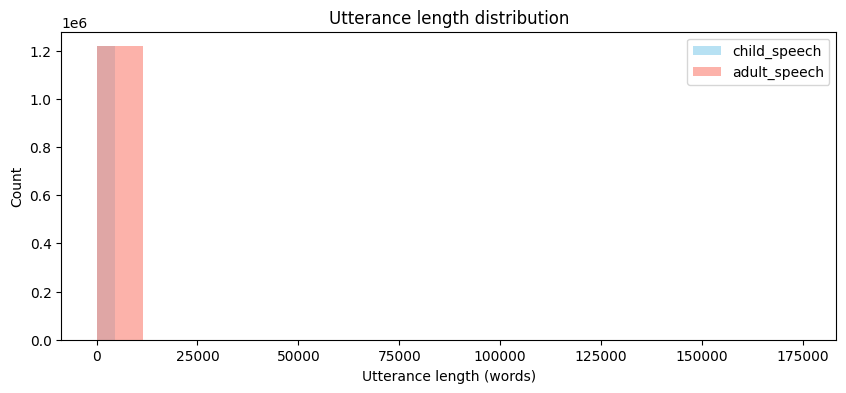

In [83]:
# Assume canonical_df is output of ConversationMerger.build_child_prompted_pairs
stats = ConversationStats(canonical_df, child_col="child_speech", adult_col="adult_speech")
print(stats.basic_stats())
stats.plot_length_distribution(bins=15)
